In [1]:
import torch
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from pathlib import Path
import os
from PIL import Image
import torchvision.transforms as transforms
import cv2
import random
from typing import Any, Dict, List

from lang_sam import LangSAM
from lang_sam.utils import draw_segmentation_masks

# since utils in the child directory
sys.path.insert(0, './Inpaint-Anything/')
from utils import load_img_to_array, save_array_to_img, dilate_mask, \
    show_mask, show_points, get_clicked_point
from lama_inpaint import inpaint_img_with_lama
from sam_segment import predict_masks_with_sam
from stable_diffusion_inpaint import fill_img_with_sd

%matplotlib inline

/home/mukul/Documents/Avataar/Pose-editing/.inpaint_anything/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mukul/Documents/Avataar/Pose-editing/.inpaint_anything/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mukul/Documents/Avataar/Pose-editing/Inpaint-Anything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/mukul/Documents/A

Detectron v2 is not installed


/home/mukul/Documents/Avataar/Pose-editing/.inpaint_anything/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
sd_prompt = "royal election chair"
seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
data_dir = './pose_editing_examples/'

In [3]:
model = LangSAM()

/home/mukul/Documents/Avataar/Pose-editing/.inpaint_anything/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/mukul/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/home/mukul/Documents/Avataar/Pose-editing/.inpaint_anything/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/mukul/Documents/Avataar/Pose-editing/.inpaint_anything/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/mukul/Documents/Avataar/Pose-editing/.inpaint_anything/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


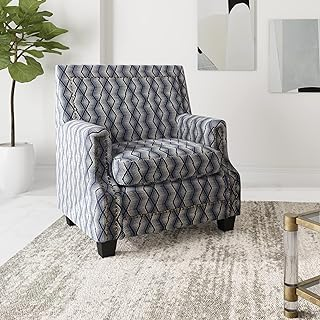

In [4]:
image_pil = Image.open("./pose_editing_examples/sofa.jpg").convert("RGB")
text_prompt = "sofa"
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)
image_pil

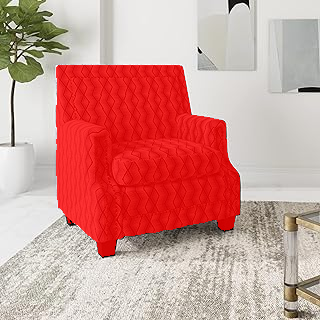

In [5]:
# Masked image
transform = transforms.Compose([
    transforms.PILToTensor()
])

img_tensor = transform(image_pil)
mask_image = draw_segmentation_masks(img_tensor, masks, colors="red")
transform = transforms.ToPILImage()
trans_img = transform(mask_image)
trans_img

## Remove Masked object from the scene

In [5]:
img = load_img_to_array("./pose_editing_examples/Modi_2.jpg")
masks = masks.detach().cpu().numpy().astype(np.uint8) * 255
masks = [dilate_mask(mask, 15) for mask in masks]
img_stem = Path("./pose_editing_examples/Modi_2.jpg").stem
out_dir = Path("./generated_images_task_1/") / img_stem
out_dir.mkdir(parents=True, exist_ok=True)

In [6]:
# visulaize the seg results

for idx, mask in enumerate(masks):
        # path to the results
        mask_p = out_dir / f"mask_{idx}.png"
        img_points_p = out_dir / f"with_points.png"
        img_mask_p = out_dir / f"with_{Path(mask_p).name}"

        # save the mask
        save_array_to_img(mask, mask_p)

        # save the pointed and masked image
        dpi = plt.rcParams['figure.dpi']
        height, width = img.shape[:2]
        plt.figure(figsize=(width/dpi/0.77, height/dpi/0.77))
        plt.imshow(img)
        plt.axis('off')
        plt.savefig(img_points_p, bbox_inches='tight', pad_inches=0)
        show_mask(plt.gca(), mask, random_color=False)
        plt.savefig(img_mask_p, bbox_inches='tight', pad_inches=0)
        plt.close()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# inpaint the masked image
for idx, mask in enumerate(masks):
    mask_p = out_dir / f"mask_{idx}.png"
    img_inpainted_p = out_dir / f"inpainted_with_{Path(mask_p).name}"
    img_inpainted = inpaint_img_with_lama(
        img, mask, "./Inpaint-Anything/lama/configs/prediction/default.yaml", "./Inpaint-Anything/pretrained_models/big-lama/", device=device)
    save_array_to_img(img_inpainted, img_inpainted_p)

## Image Fill

In [20]:
sd_prompt = "royal election chair"
seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
img = load_img_to_array("./pose_editing_examples/sofa.jpg")
masks = masks.detach().cpu().numpy().astype(np.uint8) * 255
masks = [dilate_mask(mask, 15) for mask in masks]
img_stem = Path("./pose_editing_examples/sofa.jpg").stem
out_dir = Path("./generated_images_task_1/") / img_stem
out_dir.mkdir(parents=True, exist_ok=True)

In [7]:
# visualize the seg results

for idx, mask in enumerate(masks):
        # path to the results
        mask_p = out_dir / f"mask_{idx}.png"
        img_points_p = out_dir / f"with_points.png"
        img_mask_p = out_dir / f"with_{Path(mask_p).name}"

        # save the mask
        save_array_to_img(mask, mask_p)

        # save the pointed and masked image
        dpi = plt.rcParams['figure.dpi']
        height, width = img.shape[:2]
        plt.figure(figsize=(width/dpi/0.77, height/dpi/0.77))
        plt.imshow(img)
        plt.axis('off')
        plt.savefig(img_points_p, bbox_inches='tight', pad_inches=0)
        show_mask(plt.gca(), mask, random_color=False)
        plt.savefig(img_mask_p, bbox_inches='tight', pad_inches=0)
        plt.close()

In [8]:
for idx, mask in enumerate(masks):
        # if args.seed is not None:
        torch.manual_seed(seed=seed)
        mask_p = out_dir / f"mask_{idx}.png"
        img_filled_p = out_dir / f"filled_with_{Path(mask_p).name}"
        img_filled = fill_img_with_sd(
            img, mask, sd_prompt, device=device)
        save_array_to_img(img_filled, img_filled_p)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/mukul/Documents/Avataar/Pose-editing/.inpaint_anything/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [18]:
# Temp code

# img = load_img_to_array("./pose_editing_examples/sofa.jpg")
# img.shape

im = Image.open("./pose_editing_examples/sofa.jpg") 
im.size

(320, 320)